In [136]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
  adapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/ (12.12.2021)
  further sources:
  https://keras.io/examples/variational_autoencoder_deconv/ (15.12.2021)
  https://pythonprogramming.net/autoencoders-tutorial/ (15.12.2021)
  https://www.geeksforgeeks.org/role-of-kl-divergence-in-variational-autoencoders/ (15.12.2021)
  http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/ (16.12.2021)
  https://jaketae.github.io/study/vae/ (16.12.2021)
  https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb (16.12.2021)
  https://www.tensorflow.org/tutorials/generative/cvae (16.12.2021)

'''

import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

TODO:
- refactor and document
- visualize required epochs for latent_dim=32
- answer questions

In [137]:
tf.compat.v1.disable_eager_execution()

In [138]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

In [139]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
latent_dim = 2
batch_size = 128
hidden_size = 256
no_epochs = 100
validation_split = 0.2
verbosity = 1
num_channels = 1

In [140]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [141]:
# # =================
# # Encoder
# # =================

# Definition
i = Input(shape=input_shape, name='encoder_input')
x = Flatten()(i)
x = Dense(hidden_size, activation="relu")(x)
x = Dense(hidden_size, activation='relu')(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim,), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_10 (Flatten)           (None, 784)          0           ['encoder_input[0][0]']          
                                                                                                  
 dense_51 (Dense)               (None, 256)          200960      ['flatten_10[0][0]']             
                                                                                                  
 dense_52 (Dense)               (None, 256)          65792       ['dense_51[0][0]']               
                                                                                            

In [142]:
# =================
# Decoder
# =================

# Definition
d_i = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(hidden_size, activation="relu")(d_i)
x = Dense(hidden_size, activation="relu")(x)
x = Dense(np.prod(list(input_shape)), activation="relu")(x)
o = Reshape(input_shape)(x)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_53 (Dense)            (None, 256)               768       
                                                                 
 dense_54 (Dense)            (None, 256)               65792     
                                                                 
 dense_55 (Dense)            (None, 784)               201488    
                                                                 
 reshape_9 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


In [143]:
# =================
# Variational Autoencoder
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2]) # output is decoded output z of encoder with input i
vae = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               267780    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         268048    
                                                                 
Total params: 535,828
Trainable params: 535,828
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Define loss function
def elbo_loss(true, pred):
    # Reconstruction loss with mean squared error because data is not binarised
    reconstruction_loss = keras.losses.mean_squared_error(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [145]:
# Compile VAE
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=opt, loss=elbo_loss)

# Train autoencoder
history = vae.fit(input_train, input_train, epochs=20, batch_size=batch_size, validation_data=(input_test, input_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 79us/sample - loss: 48.8823 - val_loss: 44.7726
Epoch 2/20
60000/60000 [==============================] - 4s 72us/sample - loss: 43.0216 - val_loss: 41.7782
Epoch 3/20
60000/60000 [==============================] - 4s 67us/sample - loss: 41.2395 - val_loss: 40.8532
Epoch 4/20
60000/60000 [==============================] - 4s 61us/sample - loss: 40.2050 - val_loss: 39.8550
Epoch 5/20
60000/60000 [==============================] - 4s 65us/sample - loss: 39.4026 - val_loss: 39.2853
Epoch 6/20
60000/60000 [==============================] - 4s 61us/sample - loss: 38.9362 - val_loss: 38.9334
Epoch 7/20
60000/60000 [==============================] - 4s 61us/sample - loss: 38.6122 - val_loss: 38.9340
Epoch 8/20
60000/60000 [==============================] - 4s 61us/sample - loss: 38.3668 - val_loss: 38.2166
Epoch 9/20
60000/60000 [==============================] - 4s 61us/sample - los

### Subtask 1: What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood?

### Subtask 2: What might the reason if we obtain good reconstructed but bad generated digits?

??
When the reconstruction works well but the generation does not, the VAE remembers the training data too well and generalizes bad. The model overfits the given data.

### Subtask 3: Train the VAE

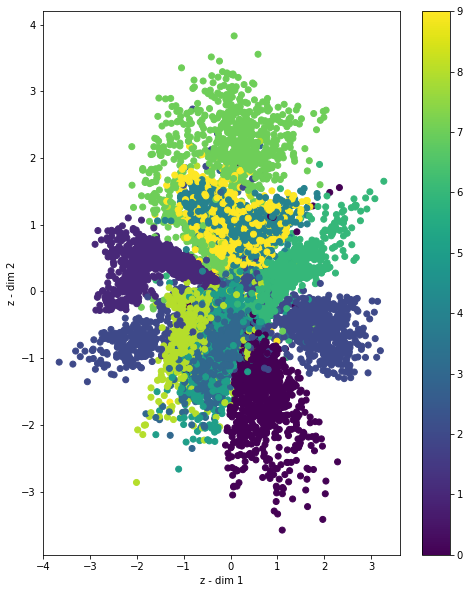

In [146]:
# =================
# adapted from: https://keras.io/examples/variational_autoencoder_deconv/
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

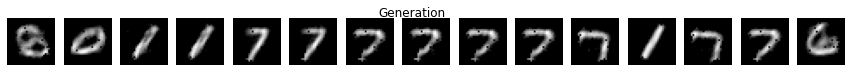

In [147]:
def vis_generation(num_samples):
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    fig.suptitle('Generation')
    for i in range(num_samples):
        z_sample = np.random.normal(size=latent_dim) * 4
        out = decoder.predict(np.array([z_sample]))
        out_reshaped = out[0].reshape(img_width, img_height, num_channels)

        axs[i].imshow(out_reshaped, cmap="gray")
        axs[i].axis('off')

vis_generation(15)

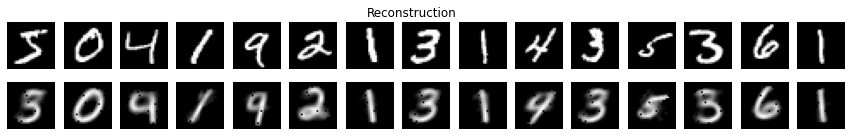

In [148]:
def vis_reconstruction(num_samples):
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples, 2))
    fig.suptitle('Reconstruction')
    for i in range(num_samples):
        axs[0][i].imshow(input_train[i], cmap="gray")
        axs[0][i].axis('off')
    for i in range(num_samples):
        out = vae.predict([input_train[i].reshape(-1, 28, 28, 1)])[0]
        axs[1][i].imshow(out, cmap="gray")
        axs[1][i].axis('off')


vis_reconstruction(15)

### Subtask 4: Plot the loss curve

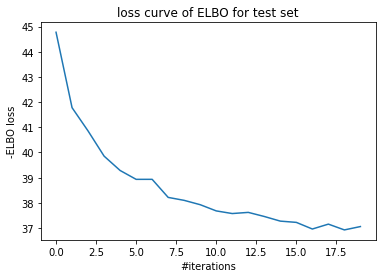

In [149]:
#print(vae.history.history)
loss_history = history.history['val_loss']

plt.plot(loss_history)
plt.title("loss curve of ELBO for test set")
plt.xlabel('#iterations')
plt.ylabel('-ELBO loss')
plt.show()

### Subtask 5: VAE with latent_dim=32

change latent_dim=32 and rerun

Results: